# 목표 
신용카드 사용자들의 개인 신상정보 데이터를 이용해 사용자의 신용카드 대금 연체 정도 예측 

# 고려할 점
* 중복 데이터를 어떻게 처리할지
* credit의 클래스 불균형을 어떻게 처리할지
* occyp_type의 결측치를 어떻게 처리할지
* family_size와 child_num의 이상치를 어떻게 처리할지 

# 1. 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

data_path = 'C:/Users/USER/DACON/creditcard/'

# 2. 데이터 불러오기

In [2]:
train = pd.read_csv(data_path+'train.csv')
test = pd.read_csv(data_path+'test.csv')
submission = pd.read_csv(data_path+'sample_submission.csv')

# 3. 데이터 전처리

## (1) 데이터 준비하기

In [3]:
# credit 변수 저장 및 제거
y = train.credit
train = train.drop('credit', axis=1, inplace=False)

In [4]:
# train과 test data 합치기
df = pd.concat([train, test], axis=0)

In [5]:
# 인덱스 변수 제거
df = df.drop('index', axis=1, inplace=False)

In [6]:
# FLAG_MOBIL 변수 제거
df = df.drop('FLAG_MOBIL', axis=1, inplace=False)

## (2) 결측값 및 중복열 처리하기

### 결측값

In [7]:
df.isnull().sum()

gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
work_phone           0
phone                0
email                0
occyp_type       11323
family_size          0
begin_month          0
dtype: int64

In [8]:
# # 방법1; 직업유형 변수의 null값을 무직으로 대체
# df['occyp_type'] = df['occyp_type'].fillna('inoccupation')
# df.isnull().sum()

In [9]:
# 방법2; 그냥 직업유형 변수 drop 하기
df = df.drop('occyp_type', axis=1, inplace=False)

### 중복열

In [115]:
# 너무 많은 중복열 존재... test set까지 포함하면 더 많아질 듯
# 일단은 무시하고 진행하지만지만, 좀더 생각해봐야 되는 부분
duplicate=df[df.duplicated()]
len(duplicate)

4342

## (3) Encoding

* https://m.blog.naver.com/bosongmoon/221807518210
* https://dacon.io/competitions/official/235713/codeshare/2510?page=1&dtype=recent
* https://techblog-history-younghunjo1.tistory.com/99

In [116]:
df.dtypes

gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
work_phone         int64
phone              int64
email              int64
family_size      float64
begin_month      float64
dtype: object

### Binary

* Binary: gender/car/reality/work_phone/phone/email
* 이때, work_phone/phone/email은 이미 자료가 인코딩된 상태로 입력됨
* 인코딩 방법: Label Encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['gender'] = encoder.fit_transform(df['gender'])
df['car'] = encoder.fit_transform(df['car'])
df['reality'] = encoder.fit_transform(df['reality'])

df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,2.0,-6.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,3.0,-5.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,2.0,-22.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,2.0,-37.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,2.0,-26.0


### Ordinal

* Ordinal; edu_type
* 인코딩 방법: Mapping

In [118]:
df.edu_type.unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [11]:
edu_order = {
    'Lower secondary' : 0, # 중학교 미만
    'Secondary / secondary special' : 1, # 중학교
    'Incomplete higher' : 2, # 고등학교 중퇴
    'Higher education' : 3, # 고등학교 졸업
     'Academic degree' : 4 # 학사 이상
}

In [120]:
df.edu_type = df.edu_type.map(edu_order)
df.edu_type.head()

0    3
1    1
2    3
3    1
4    3
Name: edu_type, dtype: int64

### Nominal

* Nominal: income_type/family_type/house_type/occyp_type
* 인코딩 방법: pd.get_dummies()

In [12]:
df = pd.get_dummies(df)
df.head()

,gender,car,reality,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,...,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,0,0,0,0,202500.0,-13899,-4709,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,1,1,247500.0,-11380,-1540,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,1,1,0,450000.0,-19087,-4434,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,1,0,202500.0,-15088,-2092,0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,0,1,1,0,157500.0,-15037,-2105,0,0,0,...,1,0,0,0,0,1,0,0,0,0


### Numerical

* Numerical: child_num/family_size/income_total/DAYS_BIRTH/DAYS_EMPLOYED/begin_month
* child_num/family_size: 이상치 처리 
* income_total: 로그변환
* DAYS_BIRTH/DAYS_EMPLOYED/begin_month: 데이터 변환 

In [122]:
# # DAYS_BIRTH -> Age(년)

# # 날짜를 나이로 바꿔주는 사용자 정의 함수
# def days_to_age(x):
#     res = (x*-1)/365
#     return res

# # Age 변수 생성
# df['Age'] = df['DAYS_BIRTH'].apply(days_to_age)
# df = df.astype({'Age':'int'})

# # DAYS_BIRTH 변수 제거
# df = df.drop('DAYS_BIRTH', axis=1, inplace=False)

In [13]:
# DAYS_BIRTH -> Age(개월)

# 날짜를 나이로 바꿔주는 사용자 정의 함수
def days_to_age(x):
    res = (x*-1)/30
    return res

# Age 변수 생성
df['Age'] = df['DAYS_BIRTH'].apply(days_to_age)
df = df.astype({'Age':'int'})

# DAYS_BIRTH 변수 제거
df = df.drop('DAYS_BIRTH', axis=1, inplace=False)

In [124]:
# # DAYS_EMPLOYED -> Employed(년)

# # 양수는 무직이므로 0으로 대체
# df['Employed'] = df['DAYS_EMPLOYED'].map(lambda  x: 0 if x>0 else x)

# # Employed 변수 생성
# df['Employed'] = df['DAYS_EMPLOYED'].apply(days_to_age)
# df = df.astype({'Employed':'int'})

# # DAYS_EMPLOYED 변수 제거
# df = df.drop('DAYS_EMPLOYED', axis=1, inplace=False)

In [14]:
# DAYS_EMPLOYED -> Employed(개월)

# 날짜를 개월로 바꿔주는 사용자 정의 함수
def days_to_month(x):
    res = (x*-1)/30
    return res

# 양수는 무직이므로 0으로 대체
df['Employed'] = df['DAYS_EMPLOYED'].map(lambda  x: 0 if x>0 else x)

# Employed 변수 생성
df['Employed'] = df['DAYS_EMPLOYED'].apply(days_to_month)
df = df.astype({'Employed':'int'})

# DAYS_EMPLOYED 변수 제거
df = df.drop('DAYS_EMPLOYED', axis=1, inplace=False)

In [126]:
# begin_month -> Month

# 음수값이므로 양수로 변환
df['Month'] = abs(df['begin_month'])

# Month 변수 생성
df = df.astype({'Month': 'int'})

# begin month 변수 제거
df = df.drop('begin_month', axis=1, inplace=False)

## (4) Scaling

### cf. child_num vs family_size 중 하나만 살리기

In [127]:
# df = df.drop('child_num', axis=1, inplace=False)

### cf. income_total 로그변환

In [16]:
df['income_total'] = df['income_total'].apply(np.log)

### 표준화

* StandardScaler: 평균 0, 분산 1인 정규분포를 따르도록 변환

In [128]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# StandardScaler로 표준화
scaled = scaler.fit_transform(df)

# Numpy ndarray -> DataFrame 변환
df_scaled = pd.DataFrame(data=scaled, columns=df.columns) 

In [129]:
# # 원본 데이터(df) 확인
# print('feature들의 평균')
# print(df.mean())
# print('feature들의 분산')
# print(df.var())

In [96]:
# # 변환된 데이터(df_scaled) 확인
# print('feature들의 평균')
# print(df_scaled.mean())
# print('feature들의 분산')
# print(df_scaled.var())

### 이상치 제거

* child_num/family_size 변수에 대해서 이상치 제거
* 표준화된 z값이 95% 신뢰구간 내에 있는 데이터만 선택  

In [97]:
# zscore 변수 생성
from scipy import stats
df['zscore_child'] = stats.zscore(df['child_num'])
df['zscore_family'] = stats.zscore(df['family_size'])

# 95% 신뢰구간 내에 있는 데이터만 선택
df = df[df['zscore_child'].between(-2, 2)]
df = df[df['zscore_family'].between(-2, 2)]

# zscore 변수 제거
df = df.drop('zscore_child', axis=1, inplace=False)
df = df.drop('zscore_family', axis=1, inplace=False)

In [130]:
# # 근데 이상치가 없는 건지 차이가 없음
# df['zscore_family'] = stats.zscore(df['family_size'])
# df = df[df['zscore_family'].between(-2, 2)]
# df = df.drop('zscore_family', axis=1, inplace=False)

### 정규화

* MinMaxScaler: 데이터를 0~1 사이의 값으로 변환

In [131]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# MinMaxScaler로 표준화
scaled2 = scaler.fit_transform(df_scaled)

# Numpy ndarray -> DataFrame 변환
df_scaled2 = pd.DataFrame(data=scaled2, columns=df.columns) 

In [132]:
# # 원본 데이터(df_scaled) 확인
# print('feature들의 최소값')
# print(df_scaled.min())
# print('feature들의 최대값')
# print(df_scaled.max())

In [101]:
# # 변환된 데이터(df_scaled2) 확인
# print('feature들의 최소값')
# print(df_scaled2.min())
# print('feature들의 최대값')
# print(df_scaled2.max())

## (5) 변수 준비하기

In [133]:
# # train/test 나누기(scaling O)
# train = df_scaled2[:-10000] # 뒤에서 10000개 제외
# test = df_scaled2[-10000:] # 앞에서 10000개 제외

In [17]:
# train/test 나누기(scaling X)
train = df[:-10000] 
test = df[-10000:]

In [18]:
# X/y 나누기
X = train
y = y.astype({'credit':'int'})

Original dataset shape Counter({2: 16968, 1: 6267, 0: 3222})
Resampled dataset shape Counter({1: 16968, 2: 16968, 0: 16968})


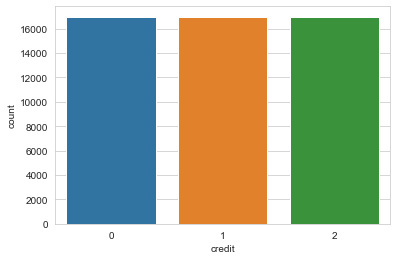

In [41]:
# # 불균형 데이터 처리
# from imblearn.over_sampling import RandomOverSampler
# from collections import Counter

# randomsample = RandomOverSampler()
# X_new, y_new = randomsample.fit_sample(X, y)

# print('Original dataset shape {}'.format(Counter(y)))
# print('Resampled dataset shape {}'.format(Counter(y_new)))
# sns.countplot(y_new)

# 4. 모델 학습
 
* 여러가지 ML 분류 모델
* 추후 딥러닝 모델도 고려

## (1) 랜덤 포레스트

### 기본 모델

In [273]:
# train/val set 분리 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_new, y_new, stratify=y_new, test_size=0.25, random_state=2)

In [274]:
from sklearn.ensemble import RandomForestClassifier

# 객체 생성
clf = RandomForestClassifier(random_state=2)

# 모델 학습
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=2)

In [275]:
# 예측확률 
y_proba = clf.predict_proba(X_val)
y_proba

array([[0.04     , 0.855    , 0.105    ],
       [0.1927381, 0.125    , 0.6822619],
       [0.03     , 0.97     , 0.       ],
       ...,
       [0.       , 0.99     , 0.01     ],
       [0.06     , 0.7      , 0.24     ],
       [0.       , 0.02     , 0.98     ]])

In [276]:
# 예측값 
y_val_onehot = pd.get_dummies(y_val)
y_val_onehot.head()

,0,1,2
43870,0,1,0
17624,0,0,1
48159,0,1,0
30125,1,0,0
37244,1,0,0


In [277]:
# Logloss 
from sklearn.metrics import log_loss
log_loss(y_val_onehot, y_proba)

0.49399598558710794

In [278]:
# for submission
submission = pd.read_csv(data_path+'sample_submission.csv')
submission.iloc[:,1:] = clf.predict_proba(test)
submission.to_csv("_sub_01.csv", index=False)
submission.head()

,index,0,1,2
0,26457,0.000000,0.220000,0.780000
1,26458,0.716667,0.043333,0.240000
2,26459,0.030000,0.050000,0.920000
3,26460,0.117460,0.078000,0.804540
4,26461,0.139621,0.342167,0.518212


### StratifiedKFold 이용

In [279]:
# StratifiedKFold 준비
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [280]:
# train set 으로 검증
outcomes = []
for n_fold, (train_index, val_index)  in enumerate(folds.split(X_new, y_new)):
    X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
    y_train, y_val = y_new.iloc[train_index], y_new.iloc[val_index]
    clf = RandomForestClassifier(random_state=2)
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)
    
np.mean(outcomes)

0.48036150302150454

In [71]:
# test set 으로 예측
outcomes = []
sub = np.zeros((test.shape[0],3))
for n_fold, (train_index, val_index)  in enumerate(folds.split(X_new, y_new)):
    X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
    y_train, y_val = y_new.iloc[train_index], y_new.iloc[val_index]
    clf = RandomForestClassifier(random_state=2)
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)

    sub += clf.predict_proba(test)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

sub = sub / 5
   
np.mean(outcomes)

0.49869831332016856

In [72]:
# for submission
submission = pd.read_csv(data_path+'sample_submission.csv')
submission.iloc[:,1:] =  sub
submission.to_csv("_sub_02.csv", index = False)

## (2) K-NN

### GridSearchCV 이용

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(weights='distance', metric='euclidean')
param_grid = [{'n_neighbors': range(3,12)}]
knn_grid = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1)
knn_grid.fit(X_train, y_train)

print('best hyper parameter:', knn_grid.best_params_)
print('best score: {0:.4f}'.format(knn_grid.best_score_))

best hyper parameter: {'n_neighbors': 3}
best score: 0.8116


In [99]:
# 예측확률 
y_proba = knn_grid.predict_proba(X_val)
y_proba

array([[0.        , 1.        , 0.        ],
       [0.19101772, 0.        , 0.80898228],
       [0.        , 1.        , 0.        ],
       ...,
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ]])

In [100]:
# 예측값 
y_val_onehot = pd.get_dummies(y_val)
y_val_onehot.head()

,0,1,2
43870,0,1,0
17624,0,0,1
48159,0,1,0
30125,1,0,0
37244,1,0,0


In [101]:
# Logloss 
from sklearn.metrics import log_loss
log_loss(y_val_onehot, y_proba)

3.3402601300551718

In [102]:
# for submission
submission = pd.read_csv(data_path+'sample_submission.csv')
submission.iloc[:,1:] = knn_grid.predict_proba(test)
submission.to_csv("_sub_03.csv", index=False)
submission.head()

,index,0,1,2
0,26457,0.0,0.249414,0.750586
1,26458,1.0,0.000000,0.000000
2,26459,0.0,0.467061,0.532939
3,26460,0.0,0.000000,1.000000
4,26461,0.0,0.815744,0.184256


## (3) SVC
* 너~무 오래 걸려서 일단 패스

In [49]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate

### 선형 분리모델

In [ ]:
svc_linear = SVC(kernel='linear', random_state=2)

# 교차검증
scores = cross_val_score(svc_linear, X_new, y_new, cv=5)

print('검증 결과 점수:', scores)
print('검증 결과 점수 평균:', scores.mean())

In [ ]:
# GridSesarchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}
svc_grid = GridSearchCV(svc_linear, param_grid=param_grid, cv=5)
svc_grid.fit(X_train, y_train)
y_proba = svc_grid.predict_proba(X_val)
log_loss(y_val_onehot, y_proba)

In [ ]:
# for submission
submission = pd.read_csv(data_path+'sample_submission.csv')
submission.iloc[:,1:] = svc_grid.predict_proba(test)
submission.to_csv("_sub_03.csv", index=False)
submission.head()

### 비선형 분리모델

In [ ]:
svc_rbf = SVC(kernel='rbf', gamma='auto', random_state=2)

# 교차검증
scores = cross_val_score(svc_rbf, X_new, y_new, cv=5)

print('검증 결과 점수:', scores)
print('검증 결과 점수 평균:', scores.mean())

In [ ]:
# GridSesarchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}
svc_grid = GridSearchCV(svc_rbf, param_grid=param_grid, cv=5)
svc_grid.fit(X_train, y_train)
y_proba = svc_grid.predict_proba(X_val)
log_loss(y_val_onehot, y_proba)

In [ ]:
# for submission
submission = pd.read_csv(data_path+'sample_submission.csv')
submission.iloc[:,1:] = svc_grid.predict_proba(test)
submission.to_csv("_sub_06.csv", index=False)
submission.head()

## (4) Logistic Regression
* https://woosa7.github.io/Classification_Regression/

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# train/val set 분리 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_new, y_new, stratify=y_new, test_size=0.25, random_state=2)

# StratifiedKFold 준비
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

### Lasso
* 변수 선택 O

In [75]:
# StratifiedKFold
outcomes = []
sub = np.zeros((test.shape[0],3))
for n_fold, (train_index, val_index)  in enumerate(folds.split(X_new, y_new)):
    X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
    y_train, y_val = y_new.iloc[train_index], y_new.iloc[val_index]
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=2)   
    lasso.fit(X_train, y_train)
    predictions = lasso.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)

    sub += lasso.predict_proba(test)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

sub = sub / 5
   
np.mean(outcomes)

1.0792063539093084

In [76]:
# for submission
submission = pd.read_csv(data_path+'sample_submission.csv')
submission.iloc[:,1:] =  sub
submission.to_csv("_sub_04.csv", index = False)

### Ridge
* 변수 선택 X

In [46]:
# StratifiedKFold
outcomes = []
sub = np.zeros((test.shape[0],3))
for n_fold, (train_index, val_index)  in enumerate(folds.split(X_new, y_new)):
    X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
    y_train, y_val = y_new.iloc[train_index], y_new.iloc[val_index]
    ridge = LogisticRegression(penalty='l2', C=2, random_state=2)   
    ridge.fit(X_train, y_train)
    predictions = ridge.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)

    sub += ridge.predict_proba(test)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

sub = sub / 5
   
np.mean(outcomes)

1.0775150054771618

In [47]:
# for submission
submission = pd.read_csv(data_path+'sample_submission.csv')
submission.iloc[:,1:] =  sub
submission.to_csv("_sub_05.csv", index = False)

## (5) LightGBM

* XGBoost와 함께 부스팅 계열 알고리즘 중 가장 각광받는 중
* XGBoost보다 학습이 빠르지만 성능은 크게 차이나지 않음 

In [21]:
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss

# train/val set 분리 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=2)

# StratifiedKFold 준비
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

In [22]:
# StratifiedKFold
outcomes = []
sub = np.zeros((test.shape[0],3))
for n_fold, (train_index, val_index)  in enumerate(folds.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    lgb = LGBMClassifier(n_estimators=1000, random_state=2)
    lgb.fit(X_train, y_train,
           eval_set=[(X_train,y_train),(X_val,y_val)],
           early_stopping_rounds=30,
           verbose=100)
    predictions = lgb.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(y_val)

    sub += lgb.predict_proba(test)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

sub = sub / 10
   
np.mean(outcomes)

Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.683907	valid_1's multi_logloss: 0.772166
[200]	training's multi_logloss: 0.616941	valid_1's multi_logloss: 0.760626
[300]	training's multi_logloss: 0.565108	valid_1's multi_logloss: 0.757645
Early stopping, best iteration is:
[365]	training's multi_logloss: 0.536178	valid_1's multi_logloss: 0.756734
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.685912	valid_1's multi_logloss: 0.769248
[200]	training's multi_logloss: 0.61698	valid_1's multi_logloss: 0.752648
[300]	training's multi_logloss: 0.565361	valid_1's multi_logloss: 0.746154
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.561606	valid_1's multi_logloss: 0.745345
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.687207	valid_1's multi_logloss: 0.762461
[200]	training's multi_logloss: 0.619637	valid_1's multi_logloss: 0.74687

0.7329346108505829

In [43]:
# # 불균형데이터 처리 후 StratifiedKFold
# # 오히려 overfitting이 발생하는 듯??
# outcomes = []
# sub = np.zeros((test.shape[0],3))
# for n_fold, (train_index, val_index)  in enumerate(folds.split(X_new, y_new)):
#     X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
#     y_train, y_val = y_new.iloc[train_index], y_new.iloc[val_index]
#     lgb = LGBMClassifier(n_estimators=1000, random_state=2)
#     lgb.fit(X_train, y_train,
#            eval_set=[(X_train,y_train),(X_val,y_val)],
#            early_stopping_rounds=30,
#            verbose=100)
#     predictions = lgb.predict_proba(X_val)
#     y_val_onehot = pd.get_dummies(y_val)

#     sub += lgb.predict_proba(test)

#     logloss = log_loss(y_val_onehot, predictions)
#     outcomes.append(logloss)

# sub = sub / 10
   
# np.mean(outcomes)

Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.865059	valid_1's multi_logloss: 0.886666
[200]	training's multi_logloss: 0.768352	valid_1's multi_logloss: 0.806635
[300]	training's multi_logloss: 0.695699	valid_1's multi_logloss: 0.746666
[400]	training's multi_logloss: 0.637229	valid_1's multi_logloss: 0.698267
[500]	training's multi_logloss: 0.588987	valid_1's multi_logloss: 0.660012
[600]	training's multi_logloss: 0.546403	valid_1's multi_logloss: 0.625846
[700]	training's multi_logloss: 0.508511	valid_1's multi_logloss: 0.595138
[800]	training's multi_logloss: 0.47405	valid_1's multi_logloss: 0.567434
[900]	training's multi_logloss: 0.44311	valid_1's multi_logloss: 0.542874
[1000]	training's multi_logloss: 0.416223	valid_1's multi_logloss: 0.521581
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.416223	valid_1's multi_logloss: 0.521581
Training until validation scores don't improve for 30 rounds
[100]

[1000]	training's multi_logloss: 0.413317	valid_1's multi_logloss: 0.521135
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.413317	valid_1's multi_logloss: 0.521135
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.864051	valid_1's multi_logloss: 0.90324
[200]	training's multi_logloss: 0.768086	valid_1's multi_logloss: 0.826542
[300]	training's multi_logloss: 0.693671	valid_1's multi_logloss: 0.766993
[400]	training's multi_logloss: 0.636513	valid_1's multi_logloss: 0.721197
[500]	training's multi_logloss: 0.587115	valid_1's multi_logloss: 0.679933
[600]	training's multi_logloss: 0.54313	valid_1's multi_logloss: 0.644362
[700]	training's multi_logloss: 0.504153	valid_1's multi_logloss: 0.614151
[800]	training's multi_logloss: 0.470405	valid_1's multi_logloss: 0.587752
[900]	training's multi_logloss: 0.440206	valid_1's multi_logloss: 0.563092
[1000]	training's multi_logloss: 0.413737	valid_1's multi_logloss:

0.5328274295441762

In [23]:
# for submission
submission = pd.read_csv(data_path+'sample_submission.csv')
submission.iloc[:,1:] =  sub
submission.to_csv("_sub_08.csv", index = False)

In [ ]:
# 내일 _sub_07 제출해보기 -> 0.8118 ㅠㅠ
# 불균형 데이터 처리 + StratifiedKFold(10) + LGBM 

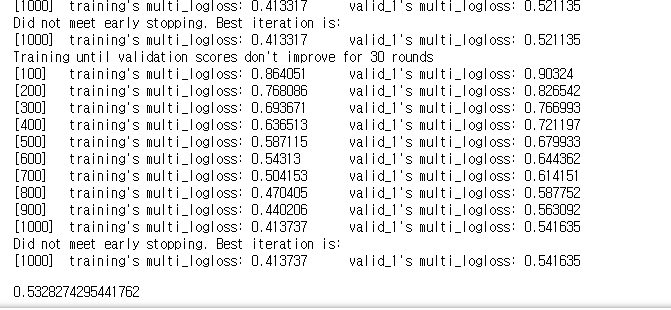